# Exploratory Data Analysis (Part 2)

## Objective
This notebook explores the cleaned datasets generated in Part 1:
1. **`label_yield.parquet`**: Annual crop yield data.
2. **`nasa_df.parquet`**: Monthly weather data (Rain, Solar Radiation, Temperature).

We aim to understand the data distributions, trends over time, and the relationship between weather variables and crop yields, with a specific focus on **Rice** for modeling.

### 1. Import Libraries and Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style for better readability
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [2]:
# Load the processed data
yield_df = pd.read_parquet('Parquet/label_yield.parquet')
nasa_df = pd.read_parquet('Parquet/nasa_df.parquet')

print("Yield Data Shape:", yield_df.shape)
print("Weather Data Shape:", nasa_df.shape)

Yield Data Shape: (89260, 4)
Weather Data Shape: (107844, 5)


### 2. Analysis of Crop Yield Data
First, we compare the scale of yields across different crops to understand the global agricultural landscape.

In [3]:
# Check first few rows
yield_df.head()

,area,item,year,label
0,Afghanistan,Maize (corn),1970-12-31,1475.7
1,Afghanistan,Maize (corn),1971-12-31,1340.0
2,Afghanistan,Maize (corn),1972-12-31,1565.2
3,Afghanistan,Maize (corn),1973-12-31,1617.0
4,Afghanistan,Maize (corn),1974-12-31,1617.0


#### 2.1 Distribution of Yields by Crop (Ranked)
To understand which crops have the highest output per hectare, we calculate the **average yield over the last 3 years** for each crop and rank them.

/var/folders/zn/lrmslqwn0g3_slr732tvb0zw0000gn/T/ipykernel_6497/1685777553.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='label', y='item', data=avg_yield_by_crop, palette='viridis')


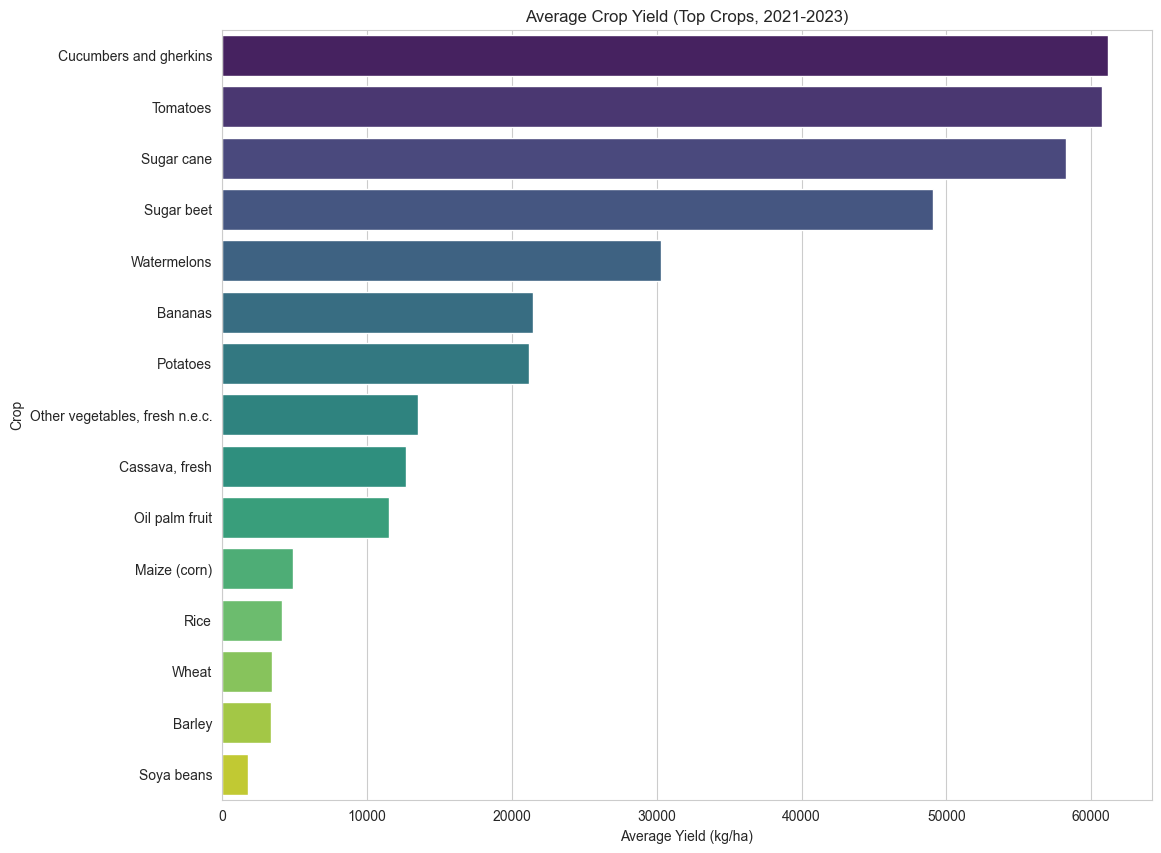

In [4]:
# 1. Identify the last 3 years in the dataset
max_year = pd.to_datetime(yield_df['year']).dt.year.max()
recent_years = [max_year, max_year-1, max_year-2]

# 2. Filter for recent data
recent_df = yield_df[pd.to_datetime(yield_df['year']).dt.year.isin(recent_years)]

# 3. Calculate average yield per crop
avg_yield_by_crop = recent_df.groupby('item')['label'].mean().reset_index()

# 4. Sort from highest to lowest
avg_yield_by_crop = avg_yield_by_crop.sort_values(by='label', ascending=False)

# 5. Plot
plt.figure(figsize=(12, 10))
sns.barplot(x='label', y='item', data=avg_yield_by_crop, palette='viridis')
plt.title(f'Average Crop Yield (Top Crops, {min(recent_years)}-{max_year})')
plt.xlabel('Average Yield (kg/ha)')
plt.ylabel('Crop')
plt.show()

### 3. Focus on Rice
Since different crops have vastly different yield ranges and growing conditions, analyzing them together can be misleading. 

**From this point forward, we will filter the data to focus exclusively on RICE.** This ensures our correlations and feature engineering insights are relevant to our specific modeling target.

In [5]:
# Filter for Rice (Looking for 'Rice, paddy' or similar)
# We use string search to be safe
rice_df = yield_df[yield_df['item'].str.contains('Rice', case=False)].copy()

print("Rice Data Shape:", rice_df.shape)
print("Unique Areas producing Rice:", rice_df['area'].nunique())
rice_df.head()

Rice Data Shape: (6248, 4)
Unique Areas producing Rice: 128


,area,item,year,label
162,Afghanistan,Rice,1970-12-31,1811.9
163,Afghanistan,Rice,1971-12-31,1750.0
164,Afghanistan,Rice,1972-12-31,1904.8
165,Afghanistan,Rice,1973-12-31,2000.0
166,Afghanistan,Rice,1974-12-31,2000.0


#### 3.1 Rice Yield Trends Over Time
We visualize how Rice production has changed over the decades for a few major producers.

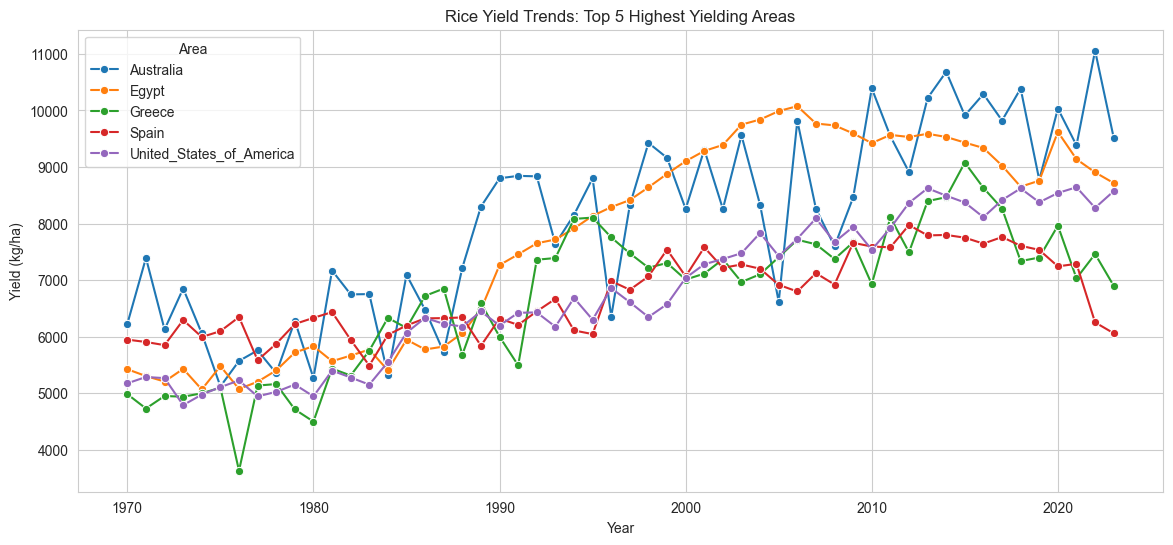

In [6]:
# Extract year number for plotting
rice_df['year_num'] = pd.to_datetime(rice_df['year']).dt.year

# Select top 5 Rice producing areas (by total volume or frequency) to keep plot clean
top_rice_areas = rice_df.groupby('area')['label'].mean().sort_values(ascending=False).head(5).index
subset_rice = rice_df[rice_df['area'].isin(top_rice_areas)]

plt.figure(figsize=(14, 6))
sns.lineplot(x='year_num', y='label', hue='area', data=subset_rice, marker='o')
plt.title('Rice Yield Trends: Top 5 Highest Yielding Areas')
plt.xlabel('Year')
plt.ylabel('Yield (kg/ha)')
plt.legend(title='Area')
plt.show()

Yield Data: 118 countries prepared.
Coordinates Source: Loaded 245 locations from GitHub.
Merged Data: Successfully linked 115 countries.


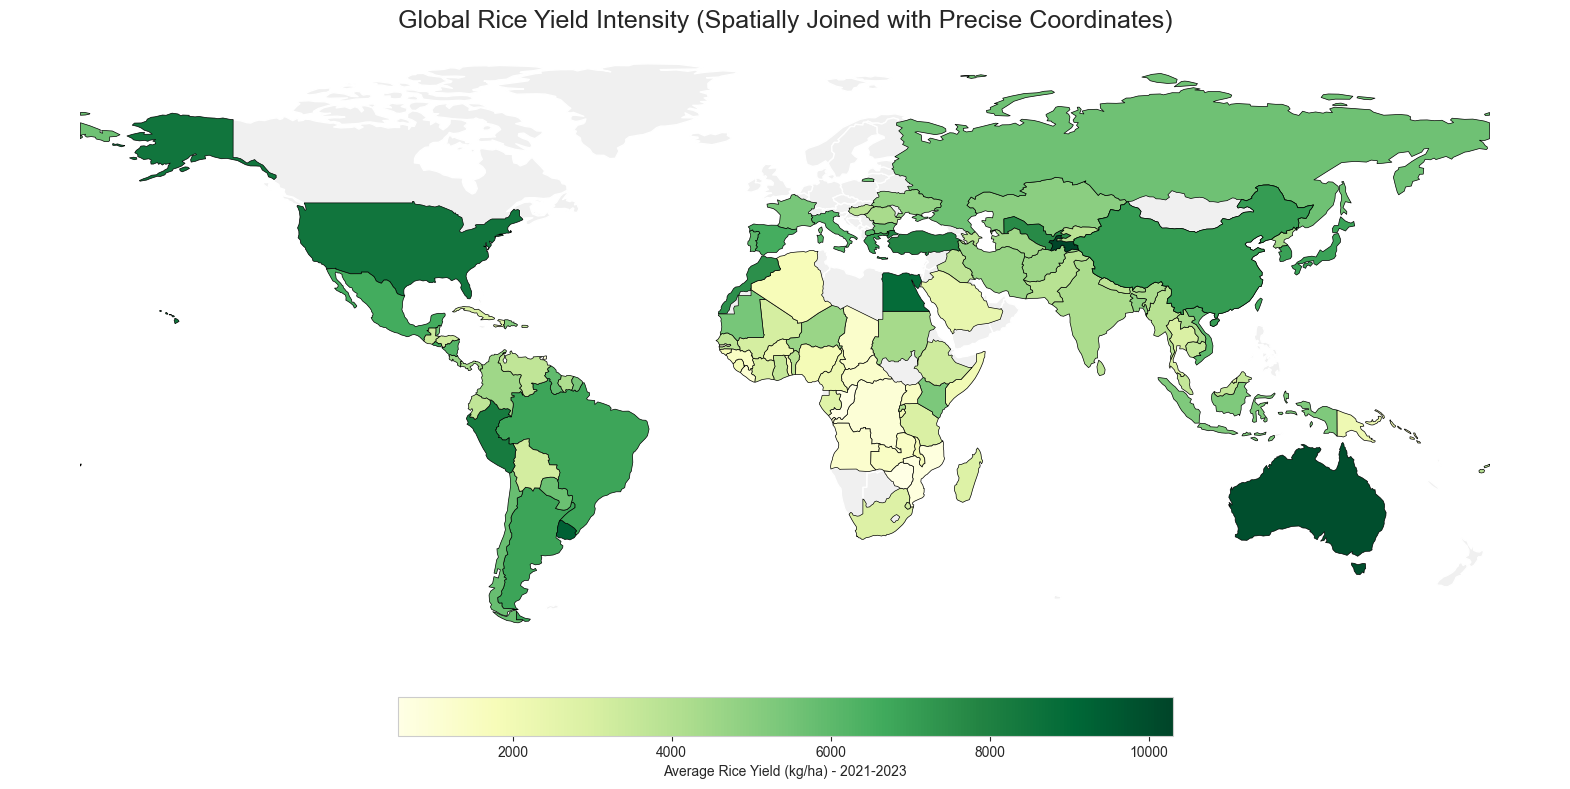

In [12]:
# --- 7.1 Geospatial Analysis: Rice Yield Map (Precise GitHub Coordinates) ---

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# 1. Load Yield Data
yield_df = pd.read_csv('Data/yield final.csv')

# Filter: Rice only, Last 3 Years
rice_df = yield_df[yield_df['Item'].str.contains('Rice', case=False, na=False)].copy()
max_year = rice_df['Year'].max()
recent_rice_df = rice_df[rice_df['Year'] >= (max_year - 2)].copy()

# Aggregate: Average Yield per Country
country_stats = recent_rice_df.groupby('Area')['Yield (kg/ha)'].mean().reset_index()
print(f"Yield Data: {len(country_stats)} countries prepared.")

# 2. Load Coordinates from GitHub
url = "https://raw.githubusercontent.com/google/dspl/master/samples/google/canonical/countries.csv"
try:
    coords_df = pd.read_csv(url)
    coords_df = coords_df.rename(columns={'name': 'google_name', 'latitude': 'lat', 'longitude': 'lon'})
    print(f"Coordinates Source: Loaded {len(coords_df)} locations from GitHub.")
except Exception as e:
    print(f"Error reading GitHub URL: {e}")
    coords_df = pd.DataFrame() 

# 3. PRECISE NAME MAPPING (FAO -> GitHub/Google Names)
# This dictionary bridges the specific differences between your two provided lists.
name_map = {
    # Americas
    'United States of America': 'United States',
    'Venezuela (Bolivarian Republic of)': 'Venezuela',
    'Bolivia (Plurinational State of)': 'Bolivia',
    'Dominican Republic': 'Dominican Republic', # Match
    'Antigua and Barbuda': 'Antigua and Barbuda', # Match
    
    # Europe
    'United Kingdom of Great Britain and Northern Ireland': 'United Kingdom',
    'Republic of Moldova': 'Moldova',
    'Russian Federation': 'Russia',
    'North Macedonia': 'Macedonia [FYROM]', # Google uses this older name
    'Czechia': 'Czech Republic',
    'Netherlands (Kingdom of the)': 'Netherlands',
    'Bosnia and Herzegovina': 'Bosnia and Herzegovina', # Match
    
    # Asia
    'Viet Nam': 'Vietnam',
    'Iran (Islamic Republic of)': 'Iran',
    'Syrian Arab Republic': 'Syria',
    'Lao People\'s Democratic Republic': 'Laos',
    'Republic of Korea': 'South Korea',
    'Democratic People\'s Republic of Korea': 'North Korea',
    'China, mainland': 'China', 
    'China, Taiwan Province of': 'Taiwan',
    'Brunei Darussalam': 'Brunei',
    'Türkiye': 'Turkey',
    'Myanmar': 'Myanmar [Burma]',
    'Palestine': 'Palestinian Territories',
    'Timor-Leste': 'East Timor', # Often listed as East Timor in older datasets
    
    # Africa
    'United Republic of Tanzania': 'Tanzania',
    'Democratic Republic of the Congo': 'Congo [DRC]',
    'Congo': 'Congo [Republic]',
    'Eswatini': 'Swaziland', # Google dataset uses old name
    'Côte d\'Ivoire': 'Côte d\'Ivoire', # Check encoding
    'Cabo Verde': 'Cape Verde',
    'Sao Tome and Principe': 'São Tomé and Príncipe',
    
    # Oceania
    'Micronesia (Federated States of)': 'Micronesia'
}

# Apply mapping to Yield Data
country_stats['mapped_name'] = country_stats['Area'].replace(name_map)

# 4. Merge
# Inner join to ensure we only map countries where we have both Yield AND Location
merged_data = country_stats.merge(coords_df, left_on='mapped_name', right_on='google_name', how='inner')
print(f"Merged Data: Successfully linked {len(merged_data)} countries.")

# 5. Spatial Join & Plotting
points_gdf = gpd.GeoDataFrame(
    merged_data,
    geometry=gpd.points_from_xy(merged_data.lon, merged_data.lat),
    crs="EPSG:4326"
)

# Load World Map Polygons
world_map_url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
world = gpd.read_file(world_map_url)

# Spatial Join: Point -> Polygon
world_with_data = gpd.sjoin(world, points_gdf, how="inner", predicate="contains")

# Plotting
fig, ax = plt.subplots(figsize=(20, 12))

# Base Layer (Grey)
world = world[world.NAME != 'Antarctica']
world.plot(ax=ax, color='#f0f0f0', edgecolor='white')

# Data Layer (Filled)
world_with_data.plot(
    column='Yield (kg/ha)', 
    ax=ax, 
    legend=True,
    legend_kwds={
        'label': f"Average Rice Yield (kg/ha) - {max_year-2}-{max_year}",
        'orientation': "horizontal",
        'shrink': 0.5,
        'pad': 0.05
    },
    cmap='YlGn', 
    edgecolor='black',
    linewidth=0.5
)

ax.set_title(f'Global Rice Yield Intensity (Spatially Joined with Precise Coordinates)', fontsize=18)
ax.set_axis_off()
plt.show()

### 4. Weather Data Analysis
We briefly inspect the weather data. While this data covers the whole world, we will later link it specifically to the Rice yield data.

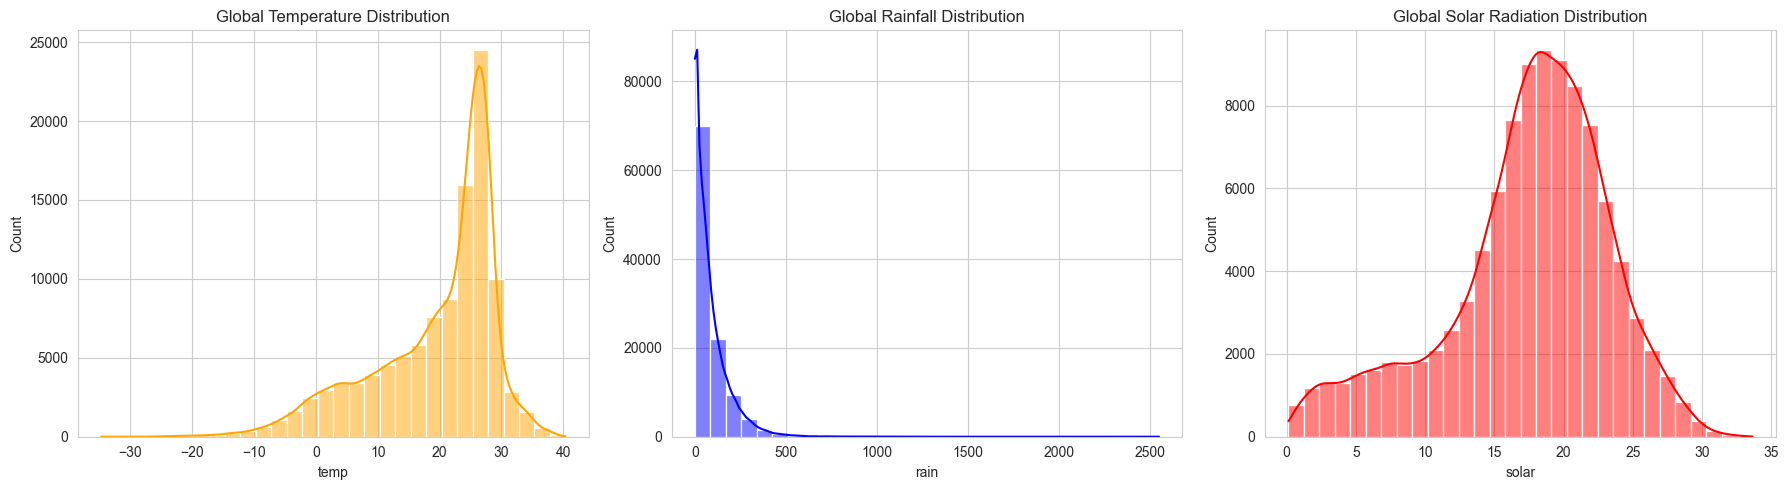

In [7]:
# Quick distribution check of weather variables
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(nasa_df['temp'].dropna(), bins=30, kde=True, ax=axes[0], color='orange')
axes[0].set_title('Global Temperature Distribution')

sns.histplot(nasa_df['rain'].dropna(), bins=30, kde=True, ax=axes[1], color='blue')
axes[1].set_title('Global Rainfall Distribution')

sns.histplot(nasa_df['solar'].dropna(), bins=30, kde=True, ax=axes[2], color='red')
axes[2].set_title('Global Solar Radiation Distribution')

plt.tight_layout()
plt.show()

### 5. Feature Engineering Support (for Model Preparation)
To build a good model, we need to decide which features are important. Here, we analyze potential **Lag Features** and **Moving Averages**.

#### 5.1 Autocorrelation (Lag Analysis)
**Hypothesis:** The yield in the current year ($t$) is highly correlated with the yield in the previous year ($t-1$). If this is true, "Lag 1" will be a powerful feature.

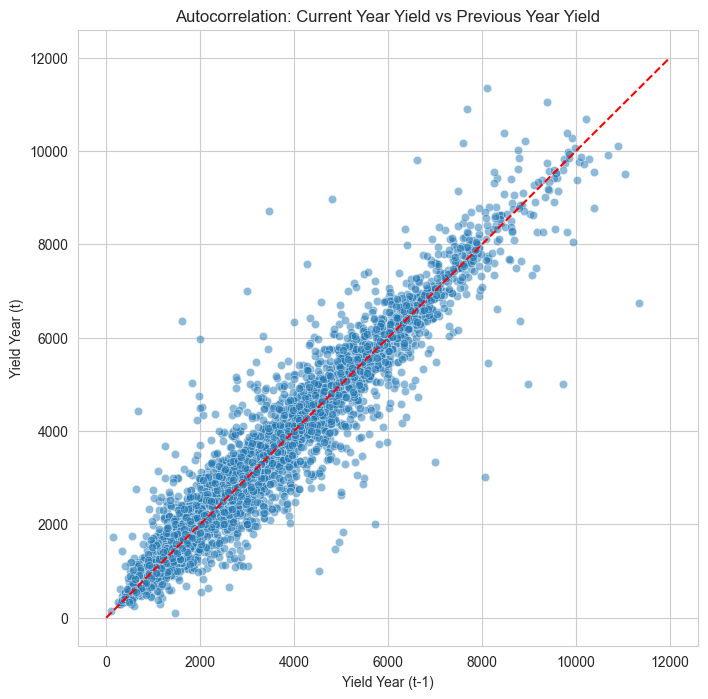

Correlation between Year(t) and Year(t-1): 0.9637
RMSE between Year(t) and Year(t-1): 512.5846


In [8]:
# Create a temporary dataframe to calculate lags
lag_analysis = rice_df.sort_values(['area', 'year_num']).copy()

# Calculate Previous Year Yield (Lag 1)
lag_analysis['yield_lag_1'] = lag_analysis.groupby('area')['label'].shift(1)

plt.figure(figsize=(8, 8))
sns.scatterplot(x='yield_lag_1', y='label', data=lag_analysis, alpha=0.5)
plt.plot([0, 12000], [0, 12000], color='red', linestyle='--')  # 45-degree line
plt.title('Autocorrelation: Current Year Yield vs Previous Year Yield')
plt.xlabel('Yield Year (t-1)')
plt.ylabel('Yield Year (t)')
plt.show()

# Calculate correlation score
corr_score = lag_analysis['label'].corr(lag_analysis['yield_lag_1'])
print(f"Correlation between Year(t) and Year(t-1): {corr_score:.4f}")

# Calculate RMSE
from sklearn.metrics import mean_squared_error
import numpy as np

valid = lag_analysis.dropna(subset=['yield_lag_1'])
rmse = np.sqrt(mean_squared_error(valid['label'], valid['yield_lag_1']))
print(f"RMSE between Year(t) and Year(t-1): {rmse:.4f}")


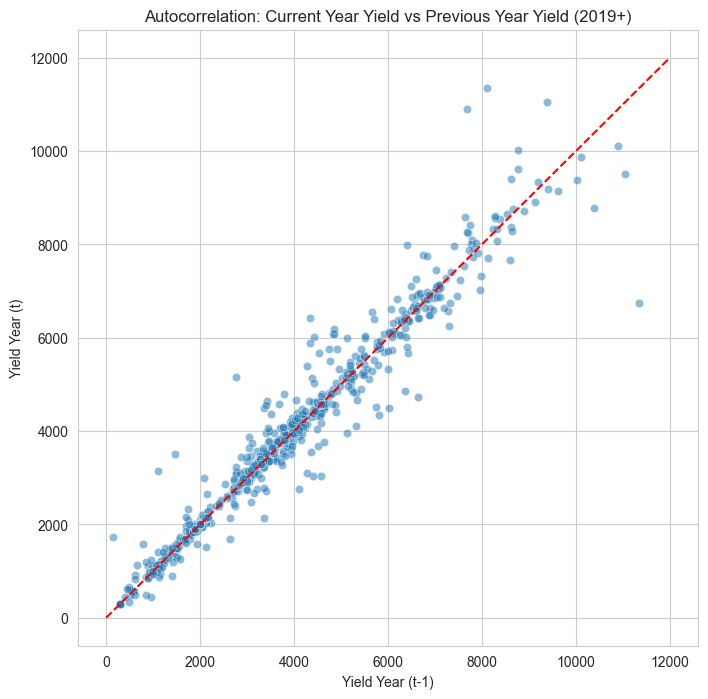

Correlation between Year(t) and Year(t-1): 0.9637
RMSE between Year(t) and Year(t-1): 512.5846


In [9]:
# Create a temporary dataframe to calculate lags
lag_analysis = rice_df.sort_values(['area', 'year_num']).copy()

# Calculate Previous Year Yield (Lag 1)
lag_analysis['yield_lag_1'] = lag_analysis.groupby('area')['label'].shift(1)

# Filter for plot (Year >= 2019) to establish recent baseline
plot_data = lag_analysis[lag_analysis['year_num'] >= 2019]

plt.figure(figsize=(8, 8))
sns.scatterplot(x='yield_lag_1', y='label', data=plot_data, alpha=0.5)
plt.plot([0, 12000], [0, 12000], color='red', linestyle='--') # 45-degree reference line
plt.title('Autocorrelation: Current Year Yield vs Previous Year Yield (2019+)')
plt.xlabel('Yield Year (t-1)')
plt.ylabel('Yield Year (t)')
plt.show()

# Calculate correlation score
corr_score = lag_analysis['label'].corr(lag_analysis['yield_lag_1'])
print(f"Correlation between Year(t) and Year(t-1): {corr_score:.4f}")

# Calculate RMSE
from sklearn.metrics import mean_squared_error
import numpy as np

valid = lag_analysis.dropna(subset=['yield_lag_1'])
rmse = np.sqrt(mean_squared_error(valid['label'], valid['yield_lag_1']))
print(f"RMSE between Year(t) and Year(t-1): {rmse:.4f}")

#### 5.2 Rolling Averages (Trend Analysis)
**Hypothesis:** Yields often follow a long-term trend. A 3-year moving average smoothes out annual noise and helps the model see the "baseline" capacity of the land.

R² (Actual vs MA_3_lag): 0.9371
RMSE (Actual vs MA_3_lag): 311.8666


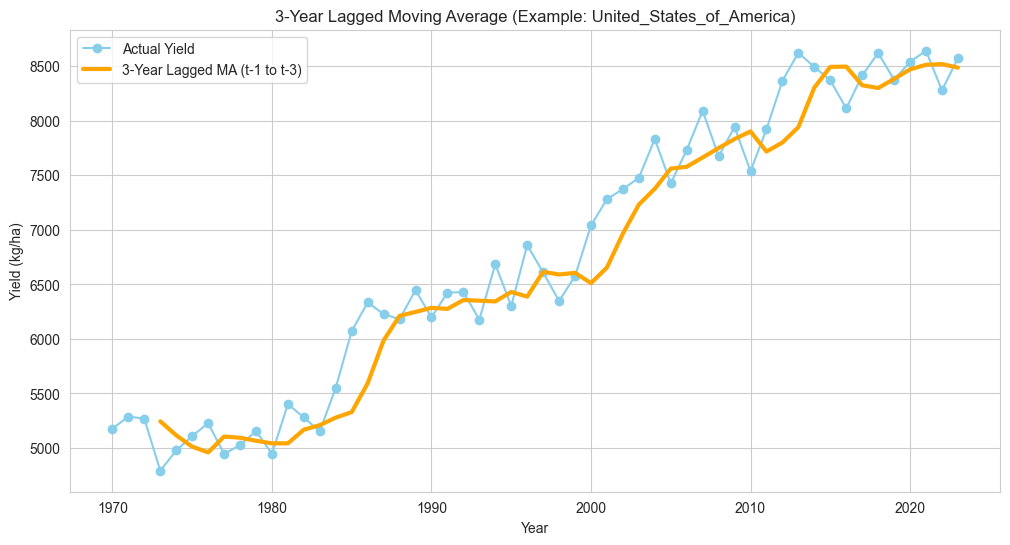

In [10]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Select country
sample_country = 'United_States_of_America'
sample_data = lag_analysis[lag_analysis['area'] == sample_country].copy()

# --- Option 1: 3-year lagged moving average ---
# Uses t-1, t-2, t-3 (no future leakage)
sample_data['MA_3_lag'] = sample_data['label'].shift(1).rolling(window=3).mean()

# Drop NA for metrics
valid = sample_data.dropna(subset=['MA_3_lag'])

# --- Compute R2 and RMSE ---
r2 = r2_score(valid['label'], valid['MA_3_lag'])
rmse = np.sqrt(mean_squared_error(valid['label'], valid['MA_3_lag']))

print(f"R² (Actual vs MA_3_lag): {r2:.4f}")
print(f"RMSE (Actual vs MA_3_lag): {rmse:.4f}")

# --- Plot ---
plt.figure(figsize=(12, 6))
plt.plot(sample_data['year_num'], sample_data['label'],
         marker='o', label='Actual Yield', color='skyblue')
plt.plot(sample_data['year_num'], sample_data['MA_3_lag'],
         linewidth=3, label='3-Year Lagged MA (t-1 to t-3)', color='orange')

plt.title(f'3-Year Lagged Moving Average (Example: {sample_country})')
plt.xlabel('Year')
plt.ylabel('Yield (kg/ha)')
plt.legend()
plt.show()


### 6. Correlation Analysis: Rice Yield vs. Weather
Finally, we verify how weather impacts **Rice specifically**. We aggregate monthly weather data to annual totals/averages and merge it with our Rice dataset.

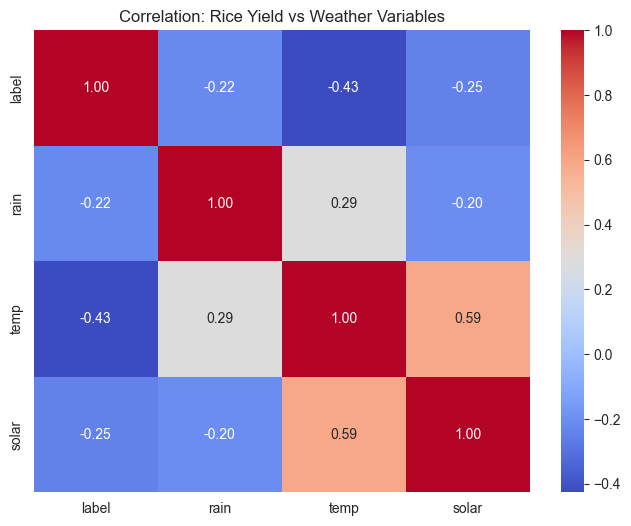

In [11]:
# 1. Extract year from weather data
nasa_df['year'] = pd.to_datetime(nasa_df['date']).dt.year

# 2. Aggregate weather by Year and Area
weather_annual = nasa_df.groupby(['area', 'year']).agg({
    'rain': 'sum',   # Total Rain needed for Rice
    'temp': 'mean',  # Average Temp
    'solar': 'mean'  # Average Sun
}).reset_index()

# 3. Merge with Rice Data
# Ensure column names match for merge
rice_merge = rice_df[['area', 'year_num', 'label']].rename(columns={'year_num': 'year'})
merged_df = pd.merge(rice_merge, weather_annual, on=['area', 'year'], how='inner')

# 4. Plot Correlation Heatmap
plt.figure(figsize=(8, 6))
corr_matrix = merged_df[['label', 'rain', 'temp', 'solar']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation: Rice Yield vs Weather Variables')
plt.show()

## Summary and Next Steps

1.  **Rice Focus:** We narrowed our analysis to Rice. The data shows clear differences in yield capacity between top producing areas.
2.  **Strong Autocorrelation:** The Lag Plot (Section 5.1) shows a very strong linear relationship between this year's yield and last year's yield. **This confirms that Lag Features (e.g., `yield_t-1`) will be critical for our predictive model.**
3.  **Trends:** The Rolling Average plot confirms that using a 3-year average as a feature can help the model understand the underlying trend, filtering out annual weather noise.
4.  **Weather Impact:** The correlation matrix gives us a baseline for how rain, temp, and sun affect Rice specifically. These features will be combined with the Lag features in the next modeling steps.